In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import math
import functools
from matplotlib import gridspec
import gradio

In [5]:
#Getting directories

style_dir=r'/content'

content_dir=r'/content'

In [6]:
#Loading the images
style=Image.open('/content/hokusai.webp')
content=Image.open('/content/content2.jpg')

style=np.array(style)
content=np.array(content)

In [7]:
def load_img(img):
    max_dim = 256
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(np.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    print(new_shape)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [8]:
content_image = load_img(content)
style_image = load_img(style)

tf.Tensor([256 208], shape=(2,), dtype=int32)
tf.Tensor([176 256], shape=(2,), dtype=int32)


In [9]:
def display(img):
    fig = plt.figure(figsize=(8, 8))
    for j,i in enumerate(img):
        image=np.array(i)
        fig.add_subplot(math.ceil(len(img)/4),len(img),j+1)
        plt.imshow(image[0],interpolation='nearest')
    plt.show()

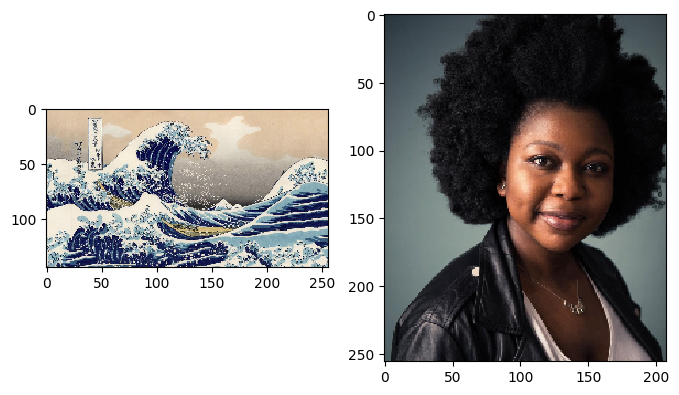

In [ ]:
display([style_image,content_image])

In [10]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
    """Returns a cropped square image."""
    shape = image.shape
    new_shape = min(shape[1], shape[2])
    offset_y = max(shape[1] - shape[2], 0) // 2
    offset_x = max(shape[2] - shape[1], 0) // 2
    image=tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, new_shape, new_shape)
    return image

@functools.lru_cache(maxsize=None)
def load_image(img, image_size=(256, 256), preserve_aspect_ratio=True):
    """Loads and preprocesses images."""
  # Cache image file locally.
#     image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
#     img = tf.io.decode_image(
#         tf.io.read_file(image_url),
#         channels=3, dtype=tf.float32)[tf.newaxis, ...]
    max_dim = 256
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(np.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    #img = crop_center(img)
    img = tf.image.resize(img, new_shape, preserve_aspect_ratio=True)
    img = img[tf.newaxis, :]
    return img

def show_n(images, titles=('',)):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()

In [11]:
def load_content_style_img(style_image,content_image):
    style_image=np.array(style_image)
    content_image=np.array(content_image)
    width,height=content_image.shape[1],content_image.shape[0]

    content_image = load_img(content_image)
    style_image = load_img(style_image)

    content_image = tf.image.resize(content_image, (width,height), preserve_aspect_ratio=True)

    style_image = crop_center(style_image)
    style_image = tf.image.resize(style_image, (256,256), preserve_aspect_ratio=True)
    style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
    return style_image,content_image

In [12]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [13]:
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

In [14]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

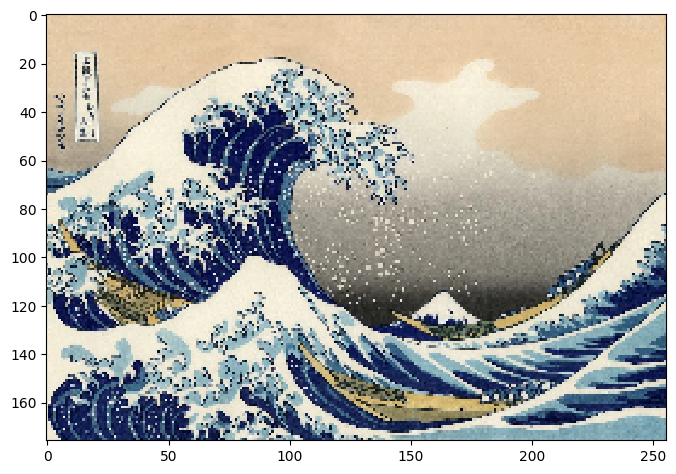

In [15]:
display([style_image])

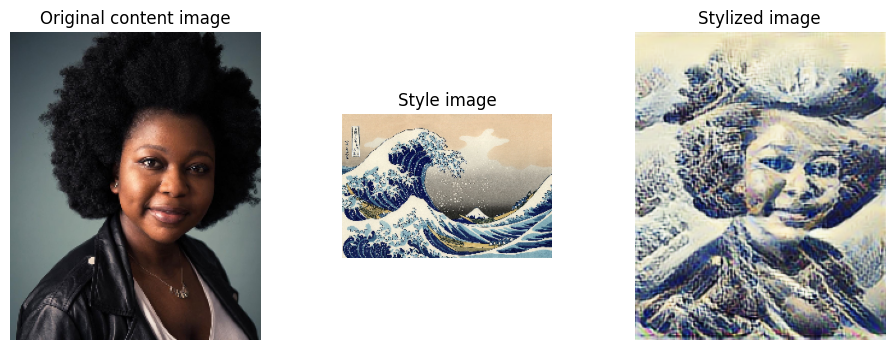

In [16]:
# show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

In [17]:
def train(style,content):
    style_image,content_image=load_content_style_img(style,content)
    outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
    stylized_image = outputs[0]
    stylized_image=tensor_to_image(stylized_image)
    arr=np.asarray(stylized_image)
    img_pil=Image.fromarray(arr)
    img_pil.save('IMAGE 1.JPG')
    return stylized_image

In [18]:
gr=gradio.Interface(fn=train, inputs=['image','image'], outputs='image')
gr.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://bd1a865d99fb7685ef.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
